# BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation

Vision-Language Pre-training (VLP) has advanced the performance for many vision-language tasks. However, most existing pre-trained models only excel in either understanding-based tasks or generation-based tasks. Furthermore, performance improvement has been largely achieved by scaling up the dataset with noisy image-text pairs collected from the web, which is a suboptimal source of supervision. In this paper, we propose BLIP, a new VLP framework which transfers flexibly to both vision-language understanding and generation tasks. BLIP effectively utilizes the noisy web data by bootstrapping the captions, where a captioner generates synthetic captions and a filter removes the noisy ones. We achieve state-of-the-art results on a wide range of vision-language tasks, such as image-text retrieval (+2.7% in average recall@1), image captioning (+2.8% in CIDEr), and VQA (+1.6% in VQA score). BLIP also demonstrates strong generalization ability when directly transferred to videolanguage tasks in a zero-shot manner. Code, models, and datasets are released.


https://huggingface.co/Salesforce/blip-image-captioning-large


###Citation
```
@misc{https://doi.org/10.48550/arxiv.2201.12086,
  doi = {10.48550/ARXIV.2201.12086},
  
  url = {https://arxiv.org/abs/2201.12086},
  
  author = {Li, Junnan and Li, Dongxu and Xiong, Caiming and Hoi, Steven},
  
  keywords = {Computer Vision and Pattern Recognition (cs.CV), FOS: Computer and information sciences, FOS: Computer and information sciences},
  
  title = {BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation},
  
  publisher = {arXiv},
  
  year = {2022},
  
  copyright = {Creative Commons Attribution 4.0 International}
}
```




In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install mlflow   optimum open_clip_torch --quiet

! pip install psutil pynvml -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 623.0/623.0 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116

In [2]:
# Transformers installation

! pip install transformers[torch] -q
! pip install accelerate -U -q
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 6.7 MB/s eta 0:00:00


In [14]:
path_model ="/content/drive/MyDrive/models/blip_pytorch"

In [3]:
from google.colab import userdata

import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import os
import sys
import platform
from PIL import Image

In [7]:
import torch.nn as nn
from torch import cuda, bfloat16
from google.colab import userdata
import mlflow
import numpy as np

In [24]:

from google.colab import output
output.enable_custom_widget_manager()

from transformers.utils import logging
from transformers import pipeline
import transformers

In [6]:
logging.set_verbosity_error()

os.environ["TRANSFORMERS_VERBOSITY"] = "error"

In [8]:


device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
device


'cuda:0'

In [9]:
MLFLOW_TRACKING_URI="databricks"
# Specify the workspace hostname and token
DATABRICKS_HOST="https://adb-2467347032368999.19.azuredatabricks.net/"
DATABRICKS_TOKEN=userdata.get('DATABRCKS_TTOKEN')

In [10]:


if "MLFLOW_TRACKING_URI" not in os.environ:
    os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI
if "DATABRICKS_HOST" not in os.environ:
    os.environ["DATABRICKS_HOST"] = DATABRICKS_HOST
if "DATABRICKS_TOKEN" not in os.environ:
    os.environ["DATABRICKS_TOKEN"] = DATABRICKS_TOKEN

In [11]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [12]:

mlflow.set_experiment("/Users/jhuertas@capaxdiscovery.com/blip_captioning")


2024/12/18 16:17:47 INFO mlflow.tracking.fluent: Experiment with name '/Users/jhuertas@capaxdiscovery.com/blip_captioning' does not exist. Creating a new experiment.


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3911355520244679', creation_time=1734538667759, experiment_id='3911355520244679', last_update_time=1734538667759, lifecycle_stage='active', name='/Users/jhuertas@capaxdiscovery.com/blip_captioning', tags={'mlflow.experiment.sourceName': '/Users/jhuertas@capaxdiscovery.com/blip_captioning',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'jhuertas@capaxdiscovery.com',
 'mlflow.ownerId': '1331640755799986'}>

In [15]:
mlflow.end_run()

In [16]:


processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", torch_dtype=torch.float16).to("cuda")

image_path = "/content/drive/MyDrive/data/beach.jpg"
raw_image = Image.open(image_path).convert("RGB")

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))
# >>> a photography of a woman and her dog

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of a group of people standing on a beach next to the ocean
surfers on the beach with their surfboards in the water


In [17]:
model.save_pretrained(path_model)
processor.save_pretrained(path_model)

[]

array([[[133, 133, 145],
        [137, 137, 149],
        [131, 133, 145],
        ...,
        [149, 117,  68],
        [ 98,  65,  14],
        [138, 102,  54]],

       [[130, 130, 142],
        [132, 132, 144],
        [127, 129, 141],
        ...,
        [130,  98,  47],
        [101,  68,  15],
        [161, 125,  75]],

       [[127, 129, 142],
        [126, 128, 141],
        [125, 127, 140],
        ...,
        [147, 116,  62],
        [152, 119,  65],
        [139, 108,  53]],

       ...,

       [[111, 111, 111],
        [112, 112, 112],
        [112, 112, 112],
        ...,
        [ 95,  64,  33],
        [ 95,  64,  33],
        [ 98,  67,  38]],

       [[111, 111, 111],
        [111, 111, 111],
        [111, 111, 111],
        ...,
        [ 94,  63,  32],
        [ 93,  62,  31],
        [ 95,  64,  35]],

       [[113, 113, 111],
        [114, 114, 112],
        [114, 114, 112],
        ...,
        [ 97,  66,  35],
        [ 95,  64,  33],
        [ 99,  68,  39]]], dtype=uint8)
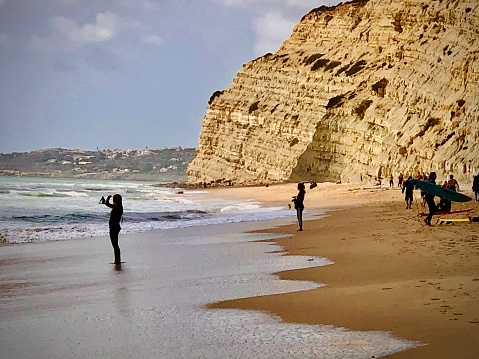

In [18]:
np.array(raw_image)

In [26]:
pipe = pipeline( model=path_model, image_processor=path_model, task= "image-to-text")

In [31]:
pipe.max_length=200
pipe.num_beams=5
pipe.do_sample=True
pipe.temperature=1.0

In [32]:
pipe.predict(raw_image.resize((224, 224)))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'surfers on the beach with their boards in the water'}]

In [25]:
transformers.__version__

'4.46.3'

In [34]:

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.pyfunc import PythonModel
import pprint

In [42]:
class BLIP_Captioner(PythonModel):
  def load_context(self, context):
        """
        This method initializes the tokenizer and language model
        using the specified model snapshot directory.
        """

        from transformers import BlipProcessor, BlipForConditionalGeneration
        from transformers import pipeline
        from PIL import Image
        import torch


        self.model = BlipForConditionalGeneration.from_pretrained(context.artifacts["snapshot"])
        self.processor = BlipProcessor.from_pretrained(context.artifacts["snapshot"])



  def predict(self, context, model_input, params=None):
        """
        This method generates prediction for the given input.
        """
        image_path  = model_input["path_image"][0]
        raw_image = Image.open(image_path).convert("RGB")
        # conditional image captioning
        text = "a photography of"
        inputs = self.processor(raw_image, text, return_tensors="pt")

        out = self.model.generate(**inputs)
        result = self.processor.decode(out[0], skip_special_tokens=True)
        return result


In [36]:
import numpy as np
import pandas as pd

import mlflow
from mlflow.models.signature import ModelSignature
from mlflow.types import ColSpec, DataType, ParamSchema, ParamSpec, Schema

from mlflow.models import infer_signature

model_output= [{'generated_text': 'surfers on the beach with their boards in the water'}]

model_input= {"path_image":"/content/drive/MyDrive/data/beach.jpg"}
signature = infer_signature(model_input=model_input,model_output=model_output)



# Define input example
input_example = {"path_image":"/content/drive/MyDrive/data/beach.jpg"}

In [37]:
signature

inputs: 
  ['path_image': string (required)]
outputs: 
  ['generated_text': string (required)]
params: 
  None

In [38]:
input_example

{'path_image': '/content/drive/MyDrive/data/beach.jpg'}

In [39]:
import datetime
now = datetime.datetime.now()
now.strftime("%Y-%m-%d_%H:%M:%S")

'2024-12-18_16:46:01'

In [40]:
# Get the current base version of torch that is installed, without specific version modifiers
torch_version = torch.__version__.split("+")[0]

In [43]:

# Start an MLflow run context and log the PHi3 model wrapper along with the param-included signature to
# allow for overriding parameters at inference time
now = datetime.datetime.now()

description= """Log BLIP captioner model with mlflow
BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation
https://huggingface.co/Salesforce/blip-image-captioning-large

"""
with mlflow.start_run(run_name=f"blip_captioner_log_{now.strftime('%Y-%m-%d_%H:%M:%S')}", description=description) as run:
    model_info = mlflow.pyfunc.log_model(
        "captioner",
        python_model=BLIP_Captioner(),
        # NOTE: the artifacts dictionary mapping is critical! This dict is used by the load_context()
        artifacts={"snapshot": "/content/drive/MyDrive/models/blip_pytorch"},

        pip_requirements=[
            f"torch=={torch_version}",
            f"transformers=={transformers.__version__}",
            "pillow",


        ],
        input_example=input_example,
        signature=signature,
    )

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Uploading artifacts:   0%|          | 0/15 [00:00<?, ?it/s]

Uploading /tmp/tmpisttgo7e/model/artifacts/blip_pytorch/model.safetensors:   0%|          | 0.00/896M [00:00<?…

🏃 View run blip_captioner_log_2024-12-18_16:49:05 at: https://adb-2467347032368999.19.azuredatabricks.net/ml/experiments/3911355520244679/runs/a000d60c32ab4333b6d90dda1893aa4b
🧪 View experiment at: https://adb-2467347032368999.19.azuredatabricks.net/ml/experiments/3911355520244679


In [44]:
run.to_dictionary()

{'info': {'artifact_uri': 'dbfs:/databricks/mlflow-tracking/3911355520244679/a000d60c32ab4333b6d90dda1893aa4b/artifacts',
  'end_time': None,
  'experiment_id': '3911355520244679',
  'lifecycle_stage': 'active',
  'run_id': 'a000d60c32ab4333b6d90dda1893aa4b',
  'run_name': 'blip_captioner_log_2024-12-18_16:49:05',
  'run_uuid': 'a000d60c32ab4333b6d90dda1893aa4b',
  'start_time': 1734540545199,
  'status': 'RUNNING',
  'user_id': ''},
 'data': {'metrics': {},
  'params': {},
  'tags': {'mlflow.note.content': 'Log BLIP captioner model with mlflow\nBLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation\nhttps://huggingface.co/Salesforce/blip-image-captioning-large\n\n',
   'mlflow.runColor': '#da4c4c',
   'mlflow.runName': 'blip_captioner_log_2024-12-18_16:49:05',
   'mlflow.source.name': '/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py',
   'mlflow.source.type': 'LOCAL',
   'mlflow.user': '1331640755799986'}}}

In [45]:

model_info.model_uri

'runs:/a000d60c32ab4333b6d90dda1893aa4b/captioner'

In [46]:
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

In [47]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: captioner
  flavor: mlflow.pyfunc.model
  run_id: a000d60c32ab4333b6d90dda1893aa4b

In [48]:

time1=  datetime.datetime.now()
response = loaded_model.predict({"path_image":"/content/drive/MyDrive/data/beach.jpg"})
time2=  datetime.datetime.now()
print(time2-time1)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


0:00:03.453762


In [49]:

pprint.pprint(response)

'a photography of a group of people standing on a beach next to the ocean'


In [50]:
result = mlflow.register_model(
    model_info.model_uri, "blip_captioner"
)

Successfully registered model 'blip_captioner'.
2024/12/18 16:50:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: blip_captioner, version 1
Created version '1' of model 'blip_captioner'.


In [51]:
from mlflow import MlflowClient

client = MlflowClient()

In [52]:
client.get_model_version(name="blip_captioner", version=1)

<ModelVersion: aliases=[], creation_timestamp=1734540655677, current_stage='None', description='', last_updated_timestamp=1734540693540, name='blip_captioner', run_id='a000d60c32ab4333b6d90dda1893aa4b', run_link='', source='dbfs:/databricks/mlflow-tracking/3911355520244679/a000d60c32ab4333b6d90dda1893aa4b/artifacts/captioner', status='READY', status_message='', tags={}, user_id='jhuertas@capaxdiscovery.com', version='1'>

In [53]:
import mlflow.pyfunc

model_name = "blip_captioner"
model_version = 1

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

model.predict({"path_image":"/content/drive/MyDrive/data/beach.jpg"})

2024/12/18 16:52:04 INFO mlflow.utils.databricks_utils: No workspace ID specified; if your Databricks workspaces share the same host URL, you may want to specify the workspace ID (along with the host information in the secret manager) for run lineage tracking. For more details on how to specify this information in the secret manager, please refer to the Databricks MLflow documentation.


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'a photography of a group of people standing on a beach next to the ocean'

In [55]:
f"models:/{model_name}/{model_version}"

'models:/blip_captioner/1'